In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizerFast, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
act_data = pd.read_csv("./data/BERT_action_hand.csv")

# 행동을 설명하는 문장

In [4]:
act_data

,action,효능
0,명상,명상은 긴장된 몸을 이완시킨다. 몸과 마음을 안정시키고 편안하게 만든다.
1,명상,명상은 집념과 감정적 동요에서 벗어나 안정적인 상태로 만든다.
2,명상,"명상은 신체를 이완시키면서 면역력이 강화되고, 창의적으로 만든다."
3,산책,"산책을 하면서 많은 경험을 하게된다. 이로 인해서 뇌에 더 많은 자극이 오게되고, ..."
4,산책,"신체를 자주 움직임으로써 유연성, 기동성과 근력이 향상된다."
5,산책,산책은 새로운 경험을 통해서 기분을 상쾌하게 만들 수 있다.
6,등산,등산은 운동을 통해서 심장을 많이 쓰게되고 이로 인해서 혈관안의 노폐물이 없어진다.
7,등산,"등산은 도시에서 벗어나 신선한 공기를 마신다. 신선한 공기는 폐를 좋아지게하고, 산..."
8,등산,"등산은 호흡운동을 하는데, 호흡 운동은 심폐기능을 좋게 만든다."
9,샤워,"샤워는 뜨거운 물을 사용해서 혈액순환이 촉진되고, 이로 인해서 몸속의 노폐물 배출이..."


# 차원을 설명하는 문장

In [6]:
dim_data = pd.read_csv("./data/BERT_dims.csv")

In [7]:
dim_data

,차원,설명
0,에너지,신체에 활력를 넣어줌.활동적이고 열정적으로 만듬
1,회복,병으로 인해서 상태가 안 좋아진 신체를 다시 원래대로 되돌림
2,순환,기 또는 혈류가 막혀 있는 것을 풀어줌. 혹은 이를 도와줌
3,정화,신체에 바이러스 혹은 세균을 제거함으로써. 신체의 원래 기능으로 되돌림


In [8]:
tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
model = BertModel.from_pretrained("kykim/bert-kor-base")

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# BERT 모델을 사용해서 문장의 유사도 확인
현재 bert의 per-train의 output을 mean_pooling을 이용해서 sent vector로 바꾼 후 유사도를 계산하는 방식

In [9]:
def word_sim(sent1 , sent2):
    words = [sent1, sent2]
    tokens = {'input_ids' : [] , 'attention_mask' : []}

    
    for word in words:
        new_tokens = tokenizer.encode_plus(word , max_length=128, truncation= True , padding='max_length' , return_tensors='pt')
        tokens['input_ids'].append(new_tokens['input_ids'][0])
        tokens['attention_mask'].append(new_tokens['attention_mask'][0])
        
    tokens['input_ids'] = torch.stack(tokens['input_ids'])
    tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
    
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state
    attention_mask = tokens['attention_mask']
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    summed = torch.sum(masked_embeddings,1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / summed_mask
    mean_pooled = mean_pooled.detach().numpy()
    return cosine_similarity( mean_pooled[0].reshape(1,-1) , mean_pooled[1].reshape(1,-1))[0][0]

In [10]:
act_dim = pd.DataFrame(columns = ['에너지','회복','순환','정화'], index = act_data.index)
act_dim['행동'] = act_data['action']
act_dim['효능'] = act_data['효능']

In [11]:
e_est = []
e_sents = dim_data['설명'][0]
for idx in act_data.index:
    e_est.append(word_sim(e_sents,act_data['효능'][idx]))
act_dim['에너지'] = e_est

In [12]:
h_est = []
h_sents = dim_data['설명'][1]
for idx in act_data.index:
    h_est.append(word_sim(h_sents,act_data['효능'][idx]))
act_dim['회복'] = h_est

In [13]:
c_est = []
c_sents = dim_data['설명'][2]
for idx in act_data.index:
    c_est.append(word_sim(c_sents,act_data['효능'][idx]))
act_dim['순환'] = c_est

In [14]:
p_est = []
p_sents = dim_data['설명'][3]
for idx in act_data.index:
    p_est.append(word_sim(p_sents,act_data['효능'][idx]))
act_dim['정화'] = p_est

# 행동의 각 문장에 대해서 차원의 유사도 계산

In [15]:
dim_data

,차원,설명
0,에너지,신체에 활력를 넣어줌.활동적이고 열정적으로 만듬
1,회복,병으로 인해서 상태가 안 좋아진 신체를 다시 원래대로 되돌림
2,순환,기 또는 혈류가 막혀 있는 것을 풀어줌. 혹은 이를 도와줌
3,정화,신체에 바이러스 혹은 세균을 제거함으로써. 신체의 원래 기능으로 되돌림


In [16]:
act_dim

,에너지,회복,순환,정화,행동,효능
0,0.513520,0.509551,0.568829,0.540337,명상,명상은 긴장된 몸을 이완시킨다. 몸과 마음을 안정시키고 편안하게 만든다.
1,0.537186,0.447076,0.492556,0.473456,명상,명상은 집념과 감정적 동요에서 벗어나 안정적인 상태로 만든다.
2,0.635052,0.527172,0.516261,0.573251,명상,"명상은 신체를 이완시키면서 면역력이 강화되고, 창의적으로 만든다."
3,0.575390,0.465029,0.488143,0.479553,산책,"산책을 하면서 많은 경험을 하게된다. 이로 인해서 뇌에 더 많은 자극이 오게되고, ..."
4,0.615817,0.532405,0.537350,0.542563,산책,"신체를 자주 움직임으로써 유연성, 기동성과 근력이 향상된다."
5,0.584012,0.516587,0.538995,0.533928,산책,산책은 새로운 경험을 통해서 기분을 상쾌하게 만들 수 있다.
6,0.544746,0.535868,0.591169,0.546037,등산,등산은 운동을 통해서 심장을 많이 쓰게되고 이로 인해서 혈관안의 노폐물이 없어진다.
7,0.531105,0.553687,0.572573,0.569978,등산,"등산은 도시에서 벗어나 신선한 공기를 마신다. 신선한 공기는 폐를 좋아지게하고, 산..."
8,0.511224,0.508795,0.561390,0.525942,등산,"등산은 호흡운동을 하는데, 호흡 운동은 심폐기능을 좋게 만든다."
9,0.537602,0.519983,0.594205,0.556258,샤워,"샤워는 뜨거운 물을 사용해서 혈액순환이 촉진되고, 이로 인해서 몸속의 노폐물 배출이..."


In [17]:
df_idx = [0]
pre_word = "명상"
for idx in act_dim.index:
    if pre_word != act_dim['행동'][idx]:
        pre_word = act_dim['행동'][idx]
        df_idx.append(idx)
df_idx.append(idx)

In [18]:
def get_est(callback):
    est = []
    heatmap = []
    for idx in range(0,len(df_idx)-1):
        #print(df_idx[idx],df_idx[idx+1])
        tmp = np.array(act_dim[['에너지','회복','순환','정화']].loc[df_idx[idx]:df_idx[idx+1]])
        tmp = callback(tmp, axis=0)
        heatmap.append(tmp)
    return heatmap

# 각 유사도에 대해서 callback을 사용해서 추정
min , mean , max에 대해서 추정

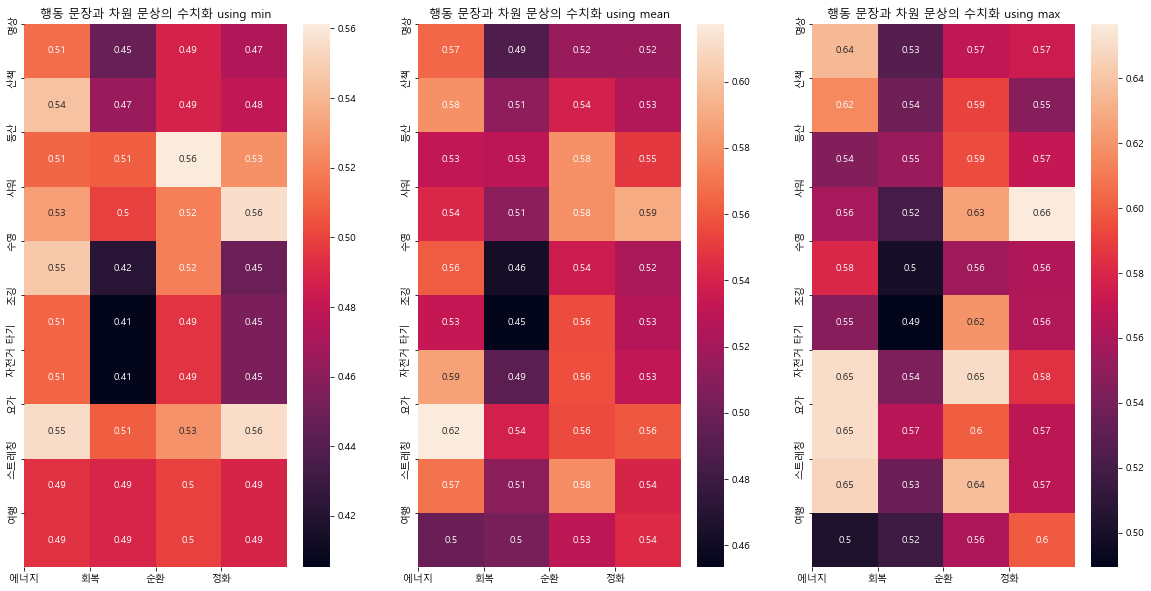

In [20]:
plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2,ax3) = plt.subplots(1,3)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

g1 = sns.heatmap(get_est(np.min),cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 문장과 차원 문상의 수치화 using min')
ax1.set_yticks(np.arange(0,len(action_list)))
ax1.set_yticklabels(action_list)
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(get_est(np.mean),cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 문장과 차원 문상의 수치화 using mean')
ax2.set_yticks(np.arange(0,len(action_list)))
ax2.set_yticklabels(action_list)
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

g3 = sns.heatmap(get_est(np.max),cbar=True,annot=True, ax=ax3)
ax3.set_title('행동 문장과 차원 문상의 수치화 using max')
ax3.set_yticks(np.arange(0,len(action_list)))
ax3.set_yticklabels(action_list)
ax3.set_xticks(np.arange(0,len(dim_list)))
ax3.set_xticklabels(dim_list)

plt.show()

# Todo
1. 현재 BERT의 hidden_layer에서 다시 mean pooling을 이용해서 sent vector를 만듬 -> max pooling 혹은 output으로만 유사도를 계산
2. 현재 사용하는 모델이 부적적하다. -> 다른 한국어 BERT모델로 변경 